In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install anesthetic
import os
os.chdir("/content/drive/MyDrive/project")

In [2]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as dists
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, multivariate_normal
from anesthetic.plot import kde_plot_1d, kde_contour_plot_2d
from torch_utils import get_limits, visualise_tension, visualise_coordinate, plot_marginalised_dists
from np_utils import simple_data, curved_data, uniform_prior_samples
from tension_net import TensionNet, TensionNet1
from tension_quantify import BayesFactor, SuspiciousnessKLDiv, LogSuspiciousness

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
X0, X1, X_prior = simple_data()
X0_tensor = torch.tensor(X0).float().to(device)
X1_tensor = torch.tensor(X1).float().to(device)
X_prior_tensor = torch.tensor(X_prior).float().to(device)

(<matplotlib.tri.tricontour.TriContourSet at 0x7fc74a9ea160>,
 <matplotlib.tri.tricontour.TriContourSet at 0x7fc74a9861d0>)

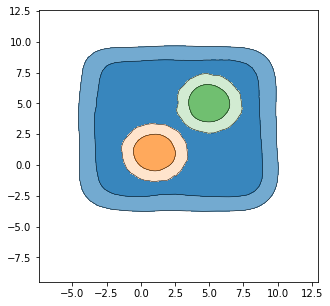

In [5]:
fig, axs = plt.subplots(figsize=(5, 5))

kde_contour_plot_2d(axs, X_prior[:, 0], X_prior[:, 1])
kde_contour_plot_2d(axs, X0[:, 0], X0[:, 1])
kde_contour_plot_2d(axs, X1[:, 0], X1[:, 1])

In [6]:
activation_fs = [F.relu, F.elu, F.leaky_relu, torch.tanh, torch.sigmoid]
activation_names = ["relu", "elu", "leaky relu", "tanh", "sigmoid"]

In [7]:
criterion = BayesFactor(hist_type="gaussian", hist_param=1, n_dist_bins=100, 
                        n_prior_bins=50).to(device)
losses_R = {}
tension_nets_R = []

for i, act_f in enumerate(activation_fs):
    tension_R = TensionNet1(2, activation_f=act_f).to(device)
    optimizer = optim.SGD(tension_R.parameters(), lr=0.0005)
    losses_R[activation_names[i]] = []

    for _ in range(500):
        optimizer.zero_grad()
        X0_1d = tension_R(X0_tensor)
        X1_1d = tension_R(X1_tensor)
        X_prior_1d = tension_R(X_prior_tensor)

        loss = criterion(X0_1d, X1_1d, X_prior_1d)
        losses_R[activation_names[i]].append(loss.item())
        loss.backward()
        optimizer.step()
    
    tension_nets_R.append(tension_R)

Text(0.5, 0.98, 'Bayes Factor')

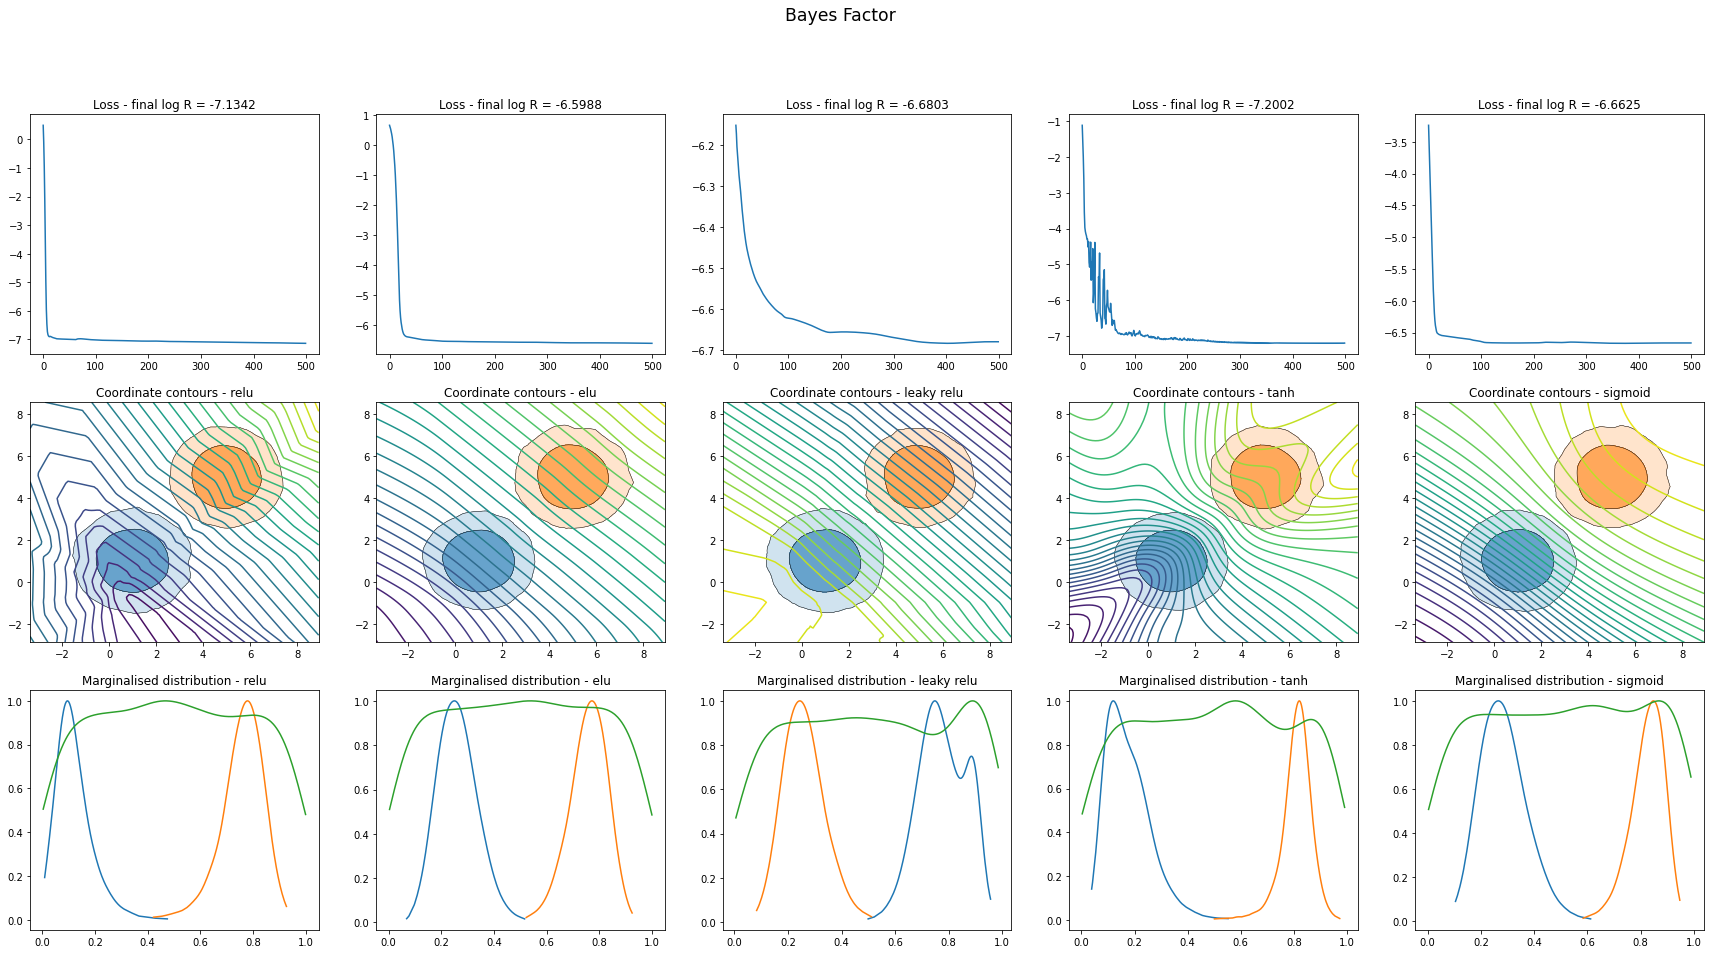

In [8]:
fig, axs = plt.subplots(3, len(activation_fs), figsize=(30, 15))
for i, act_f in enumerate(activation_fs):
    axs[0, i].plot(np.arange(500), losses_R[activation_names[i]])
    axs[0, i].set_title("Loss - final log R = " \
                        f"{round(losses_R[activation_names[i]][-1], 4)}")
    X0_1d_R = tension_nets_R[i](X0_tensor).squeeze().cpu().detach().numpy()
    X1_1d_R = tension_nets_R[i](X1_tensor).squeeze().cpu().detach().numpy()
    X_prior_1d_R = (tension_nets_R[i](X_prior_tensor).squeeze()
                    .cpu().detach().numpy())
    tension_nets_R[i].cpu()
    visualise_coordinate(fig, axs[1, i], tension_nets_R[i], X0, X1)
    axs[1, i].set_title(f"Coordinate contours - {activation_names[i]}")
    plot_marginalised_dists(fig, axs[2, i], X0_1d_R, X1_1d_R, X_prior_1d_R, 
                            flat_prior=True)
    axs[2, i].set_title(f"Marginalised distribution - {activation_names[i]}")

fig.suptitle("Bayes Factor", size="xx-large")

In [9]:
criterion = SuspiciousnessKLDiv(hist_type="gaussian", hist_param=1,
                                n_dist_bins=100, n_prior_bins=50).to(device)
losses_S = {}
tension_nets_S = []

for i, act_f in enumerate(activation_fs):
    tension_S = TensionNet1(2, activation_f=act_f).to(device)
    optimizer = optim.SGD(tension_S.parameters(), lr=0.0005)
    losses_S[activation_names[i]] = []

    for _ in range(500):
        optimizer.zero_grad()
        X0_1d = tension_S(X0_tensor)
        X1_1d = tension_S(X1_tensor)
        X_prior_1d = tension_S(X_prior_tensor)

        loss = criterion(X0_1d, X1_1d, X_prior_1d)
        losses_S[activation_names[i]].append(loss.item())
        loss.backward()
        optimizer.step()
    
    tension_nets_S.append(tension_S)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Text(0.5, 0.98, 'Suspiciousness')

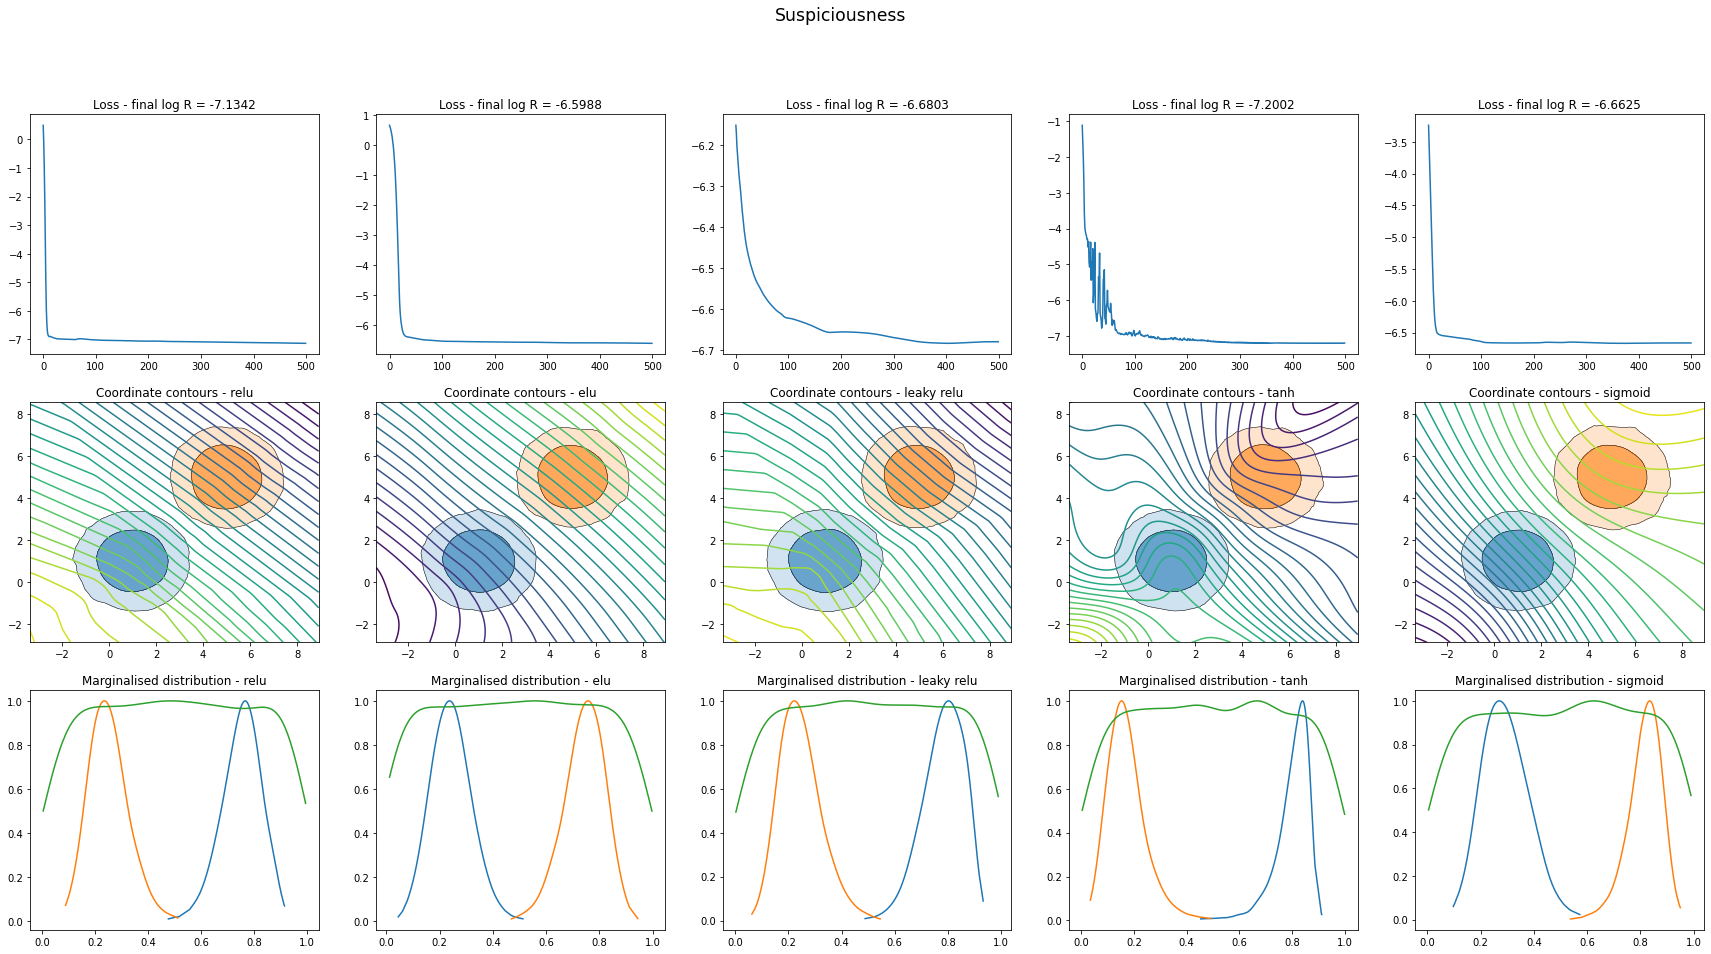

In [10]:
fig, axs = plt.subplots(3, len(activation_fs), figsize=(30, 15))
for i, act_f in enumerate(activation_fs):
    axs[0, i].plot(np.arange(500), losses_R[activation_names[i]])
    axs[0, i].set_title("Loss - final log R = " \
                        f"{round(losses_R[activation_names[i]][-1], 4)}")
    X0_1d_S = tension_nets_S[i](X0_tensor).squeeze().cpu().detach().numpy()
    X1_1d_S = tension_nets_S[i](X1_tensor).squeeze().cpu().detach().numpy()
    X_prior_1d_S = (tension_nets_S[i](X_prior_tensor).squeeze()
                    .cpu().detach().numpy())
    tension_nets_S[i].cpu()
    visualise_coordinate(fig, axs[1, i], tension_nets_S[i], X0, X1)
    axs[1, i].set_title(f"Coordinate contours - {activation_names[i]}")
    plot_marginalised_dists(fig, axs[2, i], X0_1d_S, X1_1d_S, X_prior_1d_S, 
                            flat_prior=True)
    axs[2, i].set_title(f"Marginalised distribution - {activation_names[i]}")
    

fig.suptitle("Suspiciousness", size="xx-large")

In [11]:
X0_c, X1_c, X_prior_c = curved_data()
X0_c_tensor = torch.tensor(X0_c).float().to(device)
X1_c_tensor = torch.tensor(X1_c).float().to(device)
X_prior_c_tensor = torch.tensor(X_prior_c).float().to(device)

(<matplotlib.tri.tricontour.TriContourSet at 0x7fc6eaab4b00>,
 <matplotlib.tri.tricontour.TriContourSet at 0x7fc6eaa597b8>)

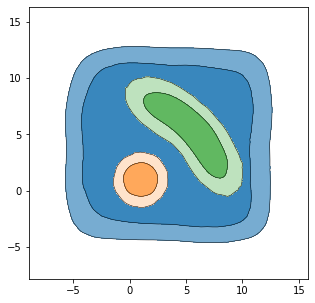

In [12]:
fig, axs = plt.subplots(figsize=(5, 5))

kde_contour_plot_2d(axs, X_prior_c[:, 0], X_prior_c[:, 1])
kde_contour_plot_2d(axs, X0_c[:, 0], X0_c[:, 1])
kde_contour_plot_2d(axs, X1_c[:, 0], X1_c[:, 1])

In [21]:
criterion = BayesFactor(hist_type="gaussian", hist_param=1, n_dist_bins=100, 
                        n_prior_bins=50).to(device)
losses_R_c = {}
tension_nets_R_c = []

for i, act_f in enumerate(activation_fs):
    tension_R = TensionNet1(2, activation_f=act_f).to(device)
    optimizer = optim.SGD(tension_R.parameters(), lr=0.001)
    losses_R_c[activation_names[i]] = []

    for _ in range(1000):
        optimizer.zero_grad()
        X0_1d = tension_R(X0_c_tensor)
        X1_1d = tension_R(X1_c_tensor)
        X_prior_1d = tension_R(X_prior_c_tensor)

        loss = criterion(X0_1d, X1_1d, X_prior_1d)
        losses_R_c[activation_names[i]].append(loss.item())
        loss.backward()
        optimizer.step()
    
    tension_nets_R_c.append(tension_R)

Text(0.5, 0.98, 'Bayes Factor')

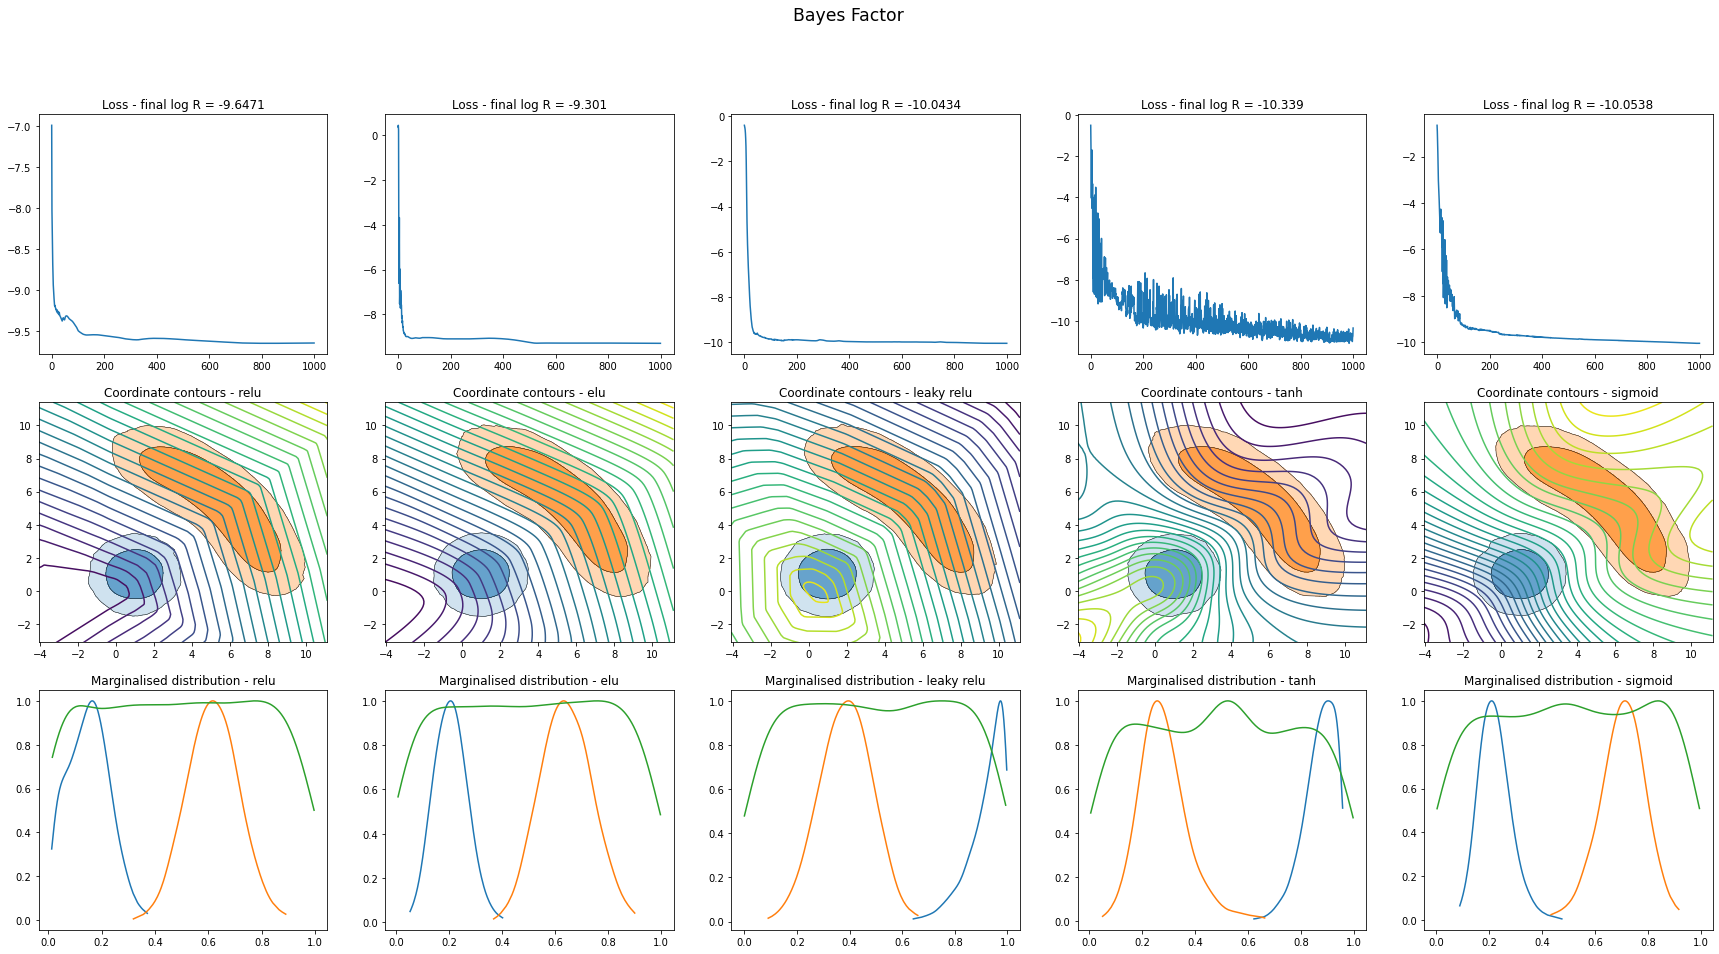

In [22]:
fig, axs = plt.subplots(3, len(activation_fs), figsize=(30, 15))
for i, act_f in enumerate(activation_fs):
    axs[0, i].plot(np.arange(1000), losses_R_c[activation_names[i]])
    axs[0, i].set_title("Loss - final log R = " \
                        f"{round(losses_R_c[activation_names[i]][-1], 4)}")
    X0_1d_R_c = tension_nets_R_c[i](X0_tensor).squeeze().cpu().detach().numpy()
    X1_1d_R_c = tension_nets_R_c[i](X1_tensor).squeeze().cpu().detach().numpy()
    X_prior_1d_R_c = (tension_nets_R_c[i](X_prior_tensor).squeeze()
                    .cpu().detach().numpy())
    tension_nets_R_c[i].cpu()
    visualise_coordinate(fig, axs[1, i], tension_nets_R_c[i], X0_c, X1_c)
    axs[1, i].set_title(f"Coordinate contours - {activation_names[i]}")
    plot_marginalised_dists(fig, axs[2, i], X0_1d_R_c, X1_1d_R_c, 
                            X_prior_1d_R_c, flat_prior=True)
    axs[2, i].set_title(f"Marginalised distribution - {activation_names[i]}")

fig.suptitle("Bayes Factor", size="xx-large")

In [23]:
criterion = SuspiciousnessKLDiv(hist_type="gaussian", hist_param=1,
                                n_dist_bins=100, n_prior_bins=50).to(device)
losses_S_c = {}
tension_nets_S_c = []

for i, act_f in enumerate(activation_fs):
    tension_S = TensionNet1(2, activation_f=act_f).to(device)
    optimizer = optim.SGD(tension_S.parameters(), lr=0.001)
    losses_S_c[activation_names[i]] = []

    for _ in range(1000):
        optimizer.zero_grad()
        X0_1d = tension_S(X0_c_tensor)
        X1_1d = tension_S(X1_c_tensor)
        X_prior_1d = tension_S(X_prior_c_tensor)

        loss = criterion(X0_1d, X1_1d, X_prior_1d)
        losses_S_c[activation_names[i]].append(loss.item())
        loss.backward()
        optimizer.step()
    
    tension_nets_S_c.append(tension_S)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Text(0.5, 0.98, 'Suspiciousness')

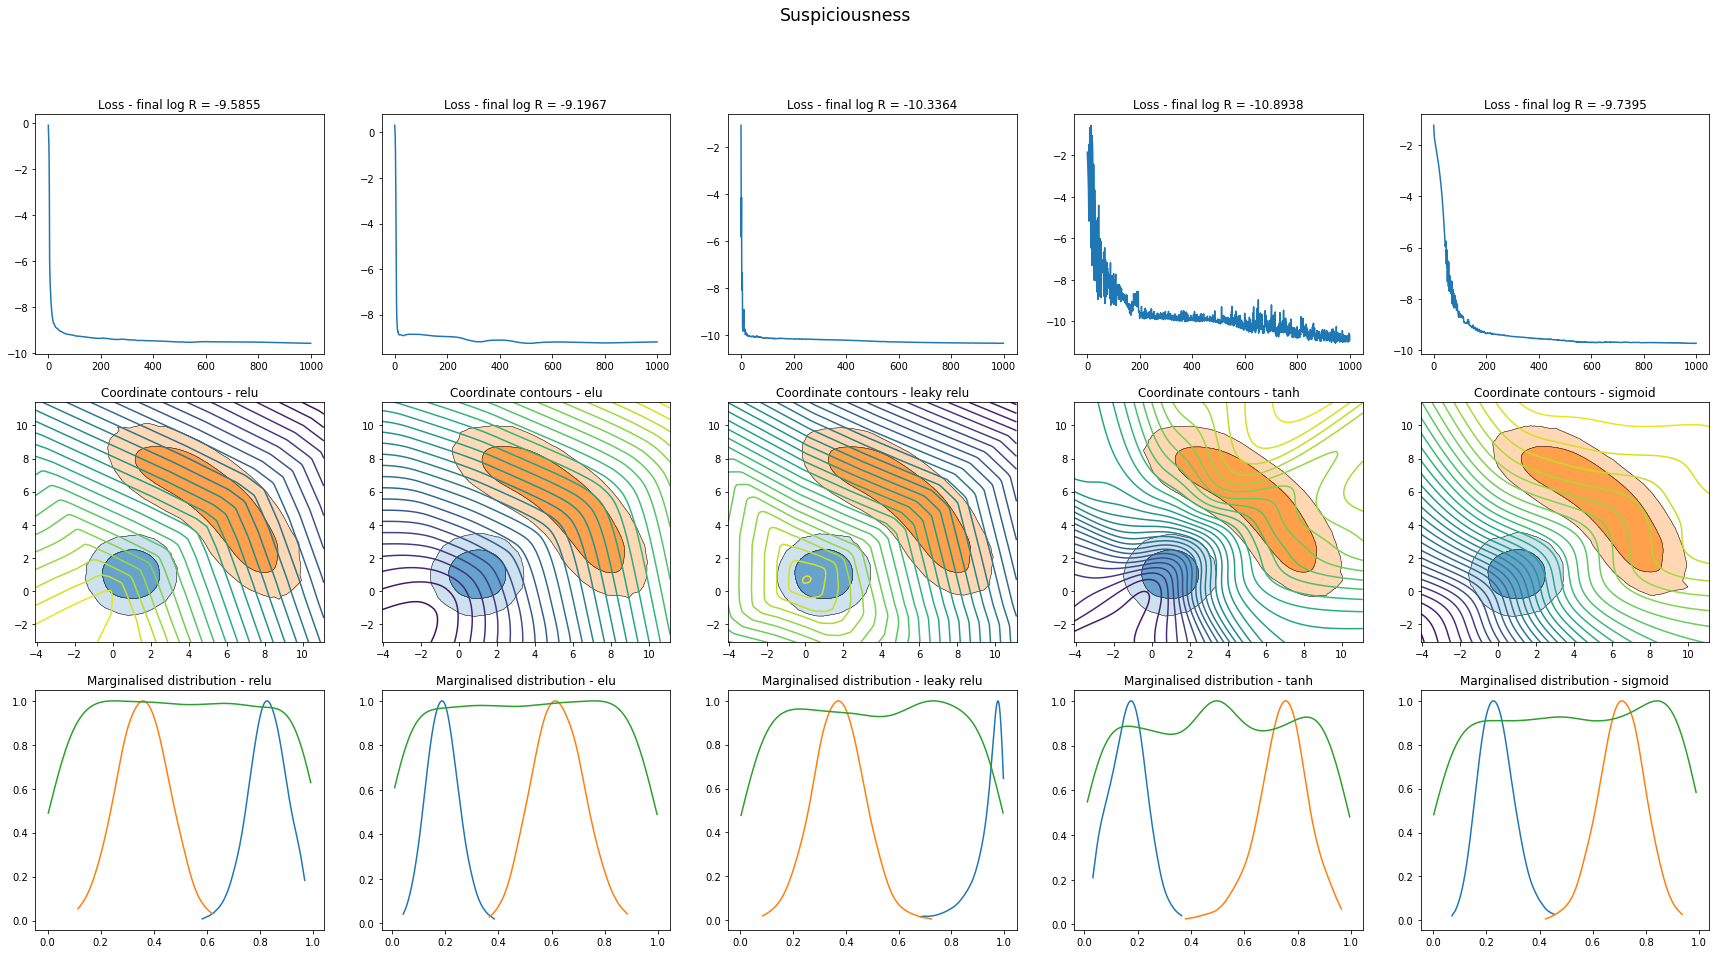

In [20]:
fig, axs = plt.subplots(3, len(activation_fs), figsize=(30, 15))
for i, act_f in enumerate(activation_fs):
    axs[0, i].plot(np.arange(1000), losses_S_c[activation_names[i]])
    axs[0, i].set_title("Loss - final log R = " \
                        f"{round(losses_S_c[activation_names[i]][-1], 4)}")
    X0_1d_S_c = tension_nets_S_c[i](X0_tensor).squeeze().cpu().detach().numpy()
    X1_1d_S_c = tension_nets_S_c[i](X1_tensor).squeeze().cpu().detach().numpy()
    X_prior_1d_S_c = (tension_nets_S_c[i](X_prior_tensor).squeeze()
                    .cpu().detach().numpy())
    tension_nets_S_c[i].cpu()
    visualise_coordinate(fig, axs[1, i], tension_nets_S_c[i], X0_c, X1_c)
    axs[1, i].set_title(f"Coordinate contours - {activation_names[i]}")
    plot_marginalised_dists(fig, axs[2, i], X0_1d_S_c, X1_1d_S_c, 
                            X_prior_1d_S_c, flat_prior=True)
    axs[2, i].set_title(f"Marginalised distribution - {activation_names[i]}")

fig.suptitle("Suspiciousness", size="xx-large")